## Importing Modules and Mounting the Google drive

Here we have imported all the modules we require and also mounted the google drive


To download Flicker8k Dataset   [link text](https://www.kaggle.com/datasets/adityajn105/flickr8k)

In [ ]:
import os                                                                       # For handling the files
import pickle                                                                   # For storing the files and some nupmy features
import numpy as np                                                              # For numerical operation
from tqdm.notebook import tqdm                                                  # For giving us some estimation about the overall process

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input         # Loading the vgg16 model and also preprocessing required for vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array         # Loading the image_preprocessing and also for loading the image
from tensorflow.keras.preprocessing.text import Tokenizer                       # Loading the text in order to find the number of unique words
from tensorflow.keras.preprocessing.sequence import pad_sequences               # We want to do padding in the text sequences. So, we have installed pad_sequences
from tensorflow.keras.models import Model                                       
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add # Installing all the stuff that required for the deep learning model construction

*** Mounting the Google Drive ***

Mounting the google drive inorder to fetch the files that's required

In [ ]:
from google.colab import drive             
drive.mount('/content/drive')          

Mounted at /content/drive


Base directory of the google drive inorder to use them while fetching and saving the model.

In [ ]:
BASE_DIR = '/content/drive/MyDrive/'      # This is the base directory of the google drive

## Importing the VGG16 Model for our usecase and loading the Flicker8k Dataset

I have used VGG16 inorder to train the images and taking the features from lsat second layer, because we want the features of the images and use them for our model building.

*** Architecture of the VGG16 Model ***

Here If you see we have dropped the last layer from the VGG16 Model. Since we don't want the prediction layer to be present. Since deep learning models fetch their own features from themselves using back-propagation, so we are taking those features and will be using in our model building. 

In [ ]:
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553476096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

*** Loading Flicker8k Dataset ***

Here we have loading our Flicker8k Dataset from the directory. We are doing the preprocessing methods for the images that we have.

We have written a for loop inorder to fetch each image and resizing them to (224,224). Now converting the image to array, since deep learning models work only with numbers. Now, I have preprocessed the data wrt to VGG16 Model (I have taken a preprocess_input function from VGG16 class). After all the preprocessing steps, I have used the vgg model to featch the featuresa nd stored them in the features dictionaey with the key as image_name and value as image features coming from the vgg16.

In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'Flicker8k_Dataset')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

*** Dumping the features into pickle file and reloading the same ***

Pickel files can be used to serialize Python object structures, which refers to the process of converting an object in the memory to a byte stream that can be stored as a binary file on disk. When we load it back to a Python program, this binary file can be de-serialized back to a Python object.

In [ ]:
pickle.dump(features, open(os.path.join(BASE_DIR,'Flicker8k_features.pkl'),'wb'))

In [ ]:
with open(os.path.join(BASE_DIR, 'Flicker8k_features.pkl'),'rb') as f:
  features = pickle.load(f)

## Loading Captions.txt file and performing all the preprocessing required for the text data

Captions.txt is the text file in which we have two columns, id and caption

*** Loading the Captions.txt ***

As the captions.txt has two columns. As we don't want the column names. So, I'm removing the column names and storing the whole text file in the captions_doc.

In [ ]:
with open('/content/captions.txt','r') as f:
  next(f)
  captions_doc = f.read()

*** Creating a dictionary where the key will be the image_id and value will be the caption ***

Here we are looping through the captions_doc of each line and splitting the based on the comma. So, Token variable would have the two indexes, in which the 1st Index is the image_id and the 2nd index would be the caption.

We are dividing the image_id by '.' because we want only the image_number not the '.jpg'.

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

*** Preprocessing of the mapping dictionary ***

Here we are doing the preprocessing of the mapping dictionary by keeping all the captions in the lower_case, replacing all the special characters and numbers by a empty space, extra space with a single space and also putting the startseq, endseq in the caption inorder to let the model know that i'ts the start and end of sentence.

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

Printing the mapping dictionary before giving it to the clean function.

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Printing the mapping again by giving it to the clean function and seeing the difference.

In [ ]:
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Here we are creating an empty list of all_captions where we have appeneded all of the mappings caption 

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

*** Initializing the Toeknizer ***

Here we have initialized the Tokenizer() function which is used for the text data

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

We got the vocab_size as 8485 which is like the len of unique words in the whole corpus

In [ ]:
vocab_size

8485

Maximum length of the caption we got as 35. So, this will be used for the padding purpose. Since, we need all of the captions of same size.

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split, Data Generator, Model Building and Fitting

Here we have splitted the data into train-test and also created the data generator in order to convert the caption into a vector form of sequence. And we have build the model for training and fitted the model using the train data.

*** Train Test Split ***

We have splitted the whole data wrt to image_ids, because we have multiple captions for a single image_id. So, we cannot divide by captions. So, we have taken 90% of the points to the train data and remaining 10% of the points to the test data.

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

*** Data Generator ***

Here we created the Data Generator fuction to taking each of the caption and convert that to vector. So, here we are concatinating the VGG16 output with the caption_vector input and y as output. We are iterating through the loop.

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Here is the example of one image_id, of what's happening and how the seq is building. Here if you see the number of words in caption is same as seq. So, seq is trying to findout the unique words from the tokenizer that we built. And from the iteration beelow it is trying to do the padding by making equilength.

In [ ]:
print('*********************************FEATURES******************************************')
print(features['963730324_0638534227'][0])
captions = mapping['963730324_0638534227']
for caption in captions:
  seq = tokenizer.texts_to_sequences([caption])[0]
  print('*********************************CAPTION*****************************************')
  print(caption)
  print('***********************************SEQ*******************************************')
  print(seq)
  #print(tokenizer.texts_to_sequences([caption])[1])
  for i in range(1, len(seq)):
    # split into input and output pairs
    in_seq, out_seq = seq[:i], seq[i]
    # pad input sequence
    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
    # encode output sequence
    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
    print('*******************************IN_SEQ******************************************')
    print(in_seq)
    print('*******************************OUT_SEQ*****************************************')
    print(out_seq)

*********************************FEATURES******************************************
[0.         0.11701059 0.         ... 0.         0.         0.        ]
*********************************CAPTION*****************************************
startseq kid is pushing shopping cart behind an adult inside consumer market endseq
***********************************SEQ*******************************************
[1, 273, 6, 596, 443, 461, 100, 27, 364, 281, 8468, 722, 2]
*******************************IN_SEQ******************************************
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
*******************************OUT_SEQ*****************************************
[0. 0. 0. ... 0. 0. 0.]
*******************************IN_SEQ******************************************
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1 273]
*******************************OUT_SEQ*******************

*** Building The Model ***

Here we are building the model where we have it for Image and sequence features. And after building the features we are going into the decoder part of the model.

So, we are taking the image_features and giving it to the Image Feature Layers.

Now we are taking the sequence_features that are already in the vector form. Now we are building the LSTM layer are getting the features.

Now after that we are concatnating the inputs1 and inputs2 and giving it to the decoder model. And at last based on the vocab size we are giving a softmax layer. So, we will be having a prob scores for every vocab in the corpus. Based on the highest prob. we will pick the next word and so on.

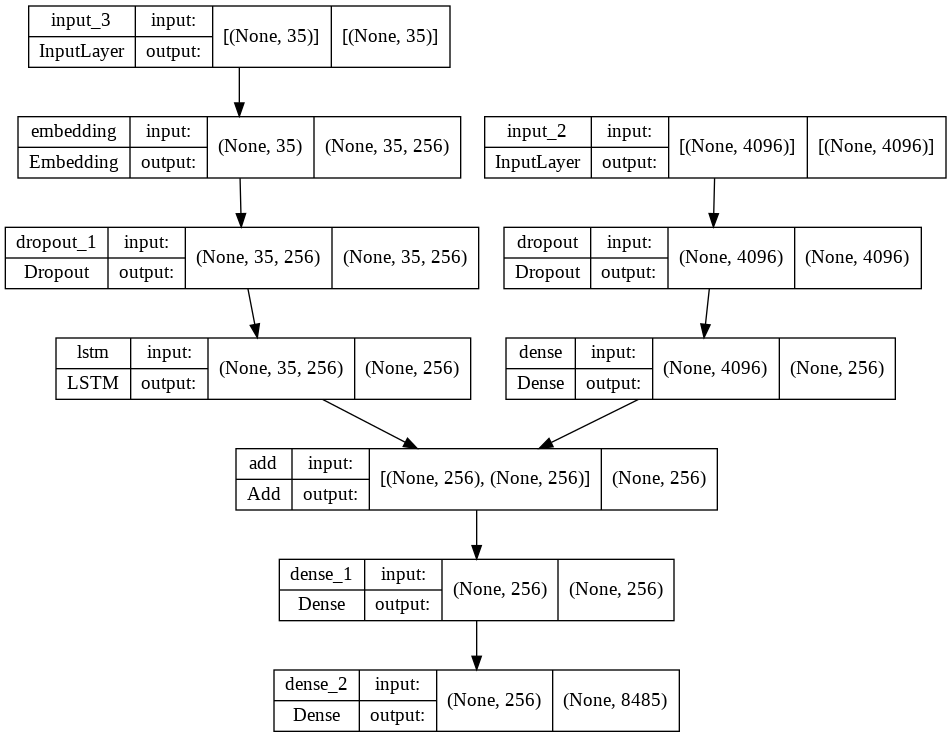

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

*** Fitting The Model ***

So, If we see in training part, we are giving in a sequence, that is first we are giving the first word in the caption to find the 2nd word. And in the 2nd iteration we are giving the first two words and finding the 3rd word and so on. So, now we are fitting the model with the train data or keys that we have splitted before.

In [ ]:
epochs = 100
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 32s 141ms/step - loss: 1.4638


Here we are saving the model in .h5 format

In [ ]:
model.save(BASE_DIR + 'best_model.h5')

## Prediction for test data

Here we are predicting using the test data and calculating the performance using the BLEU Score.

BLEU (BiLingual Evaluation Understudy) is a metric for automatically evaluating machine-translated text. The BLEU score is a number between zero and one that measures the similarity of the machine-translated text to a set of high quality reference translations.

So, here we are taking the index and word, and comparing it from the integer. If the index is found same as integer then we would return the word. Else we would return the None.



Here the word would be different words. And the index would be the unique number od the words.

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

*** Predicting the test data ***

So, here we are taking the test_data and we are going through. We are doing the same with the test data be making the tokenizing and padding. After that we are predicting the yhat and taking the argmax (that is taking the maximum probability number). So, by this we would be getting the word. So, we would continue the same until we get the endseq word. After that we weould return the all the wrds that we concatinating.

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

*** Calculating the BLEU Score by comparing the predicted captions with the actual captions ***

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.499250
BLEU-2: 0.275128


## Testing Phase

Here we are giving the different image_ids and testing how the algorithm is performing. I have also printed the actual captions and also predicted captions with the image too.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Vizualize the image
def generate_caption(image_name):
  #image_name = '1007129816_e794419615.jpg'
  image_id = image_name.split('.')[0]
  image = Image.open(os.path.join(BASE_DIR, 'Flicker8k_Dataset', image_name))
  #image = Image.open(os.path.join(BASE_DIR, 'Flicker8k_Dataset', image_name))
  captions = mapping[image_id]
  print('=====================================Actual================================================')
  for caption in captions:
    print(caption)

  # Predict the caption
  y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

  print('=====================================Predicted=============================================')
  print(y_pred)

  plt.imshow(image)

=====================================Actual================================================
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
=====================================Predicted=============================================
startseq two dogs are playing together on the pavement endseq


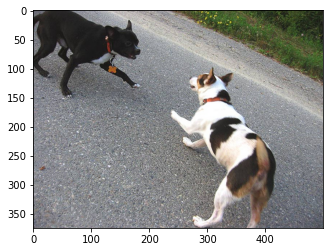

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

=====================================Actual================================================
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
=====================================Predicted=============================================
startseq little girl in pink dress is sitting in front of balloon advertisement endseq


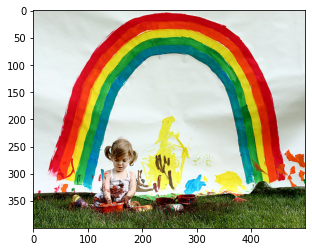

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

=====================================Actual================================================
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
=====================================Predicted=============================================
startseq two older people climbing pictures in older one blue and black skiing endseq


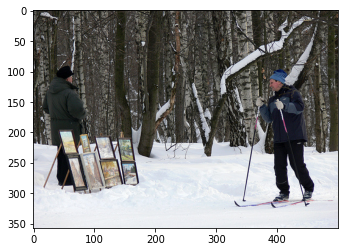

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

=====================================Actual================================================
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
=====================================Predicted=============================================
startseq girl climbing an old wooden wall endseq


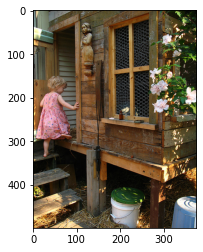

In [ ]:
generate_caption('1000268201_693b08cb0e.jpg')